In [ ]:
!pip install --upgrade pip
!pip install iqm-client
!pip install "qrisp[iqm]"
!pip -q install qiskit qrisp rustworkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of iqm-exa-common to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of iqm-exa-common to 

INFO: pip is looking at multiple versions of numpy-typing-compat to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 17.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 MB 77.0 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 127.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 138.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 125.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 128.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 76.1 MB/s  0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
  Attempting 

Benchmark JSON path (e.g. /mnt/data/your.json): /mnt/data/2026-01-29T07_13_47.314449Z.json
Fidelity threshold [default 0.992]: 0.99
Missing-edge policy drop/keep [default drop]: 
Total number of qubits [default infer from JSON or 54]: 
Run on IQM now? (y/N) [default N]: N

Loaded fidelities for 82 undirected edges (from JSON)
Kept 64 undirected edges at threshold=0.99 (missing_policy=drop)

✅ Largest grid patch found:
  shape: 2 x 4 (area=8)
  qubits used: 8
  grid edges used: 10 (expected 10)
  first 15 qubits: [7, 8, 15, 16, 23, 24, 31, 32]
  first 15 edges : [(7, 8), (7, 15), (8, 16), (15, 16), (15, 23), (16, 24), (23, 24), (23, 31), (24, 32), (31, 32)]
  missing patch edges in kept_edges: 0

Built 2D grid-cluster (graph) state circuit.
  transpiled depth: 4
  ops: 18


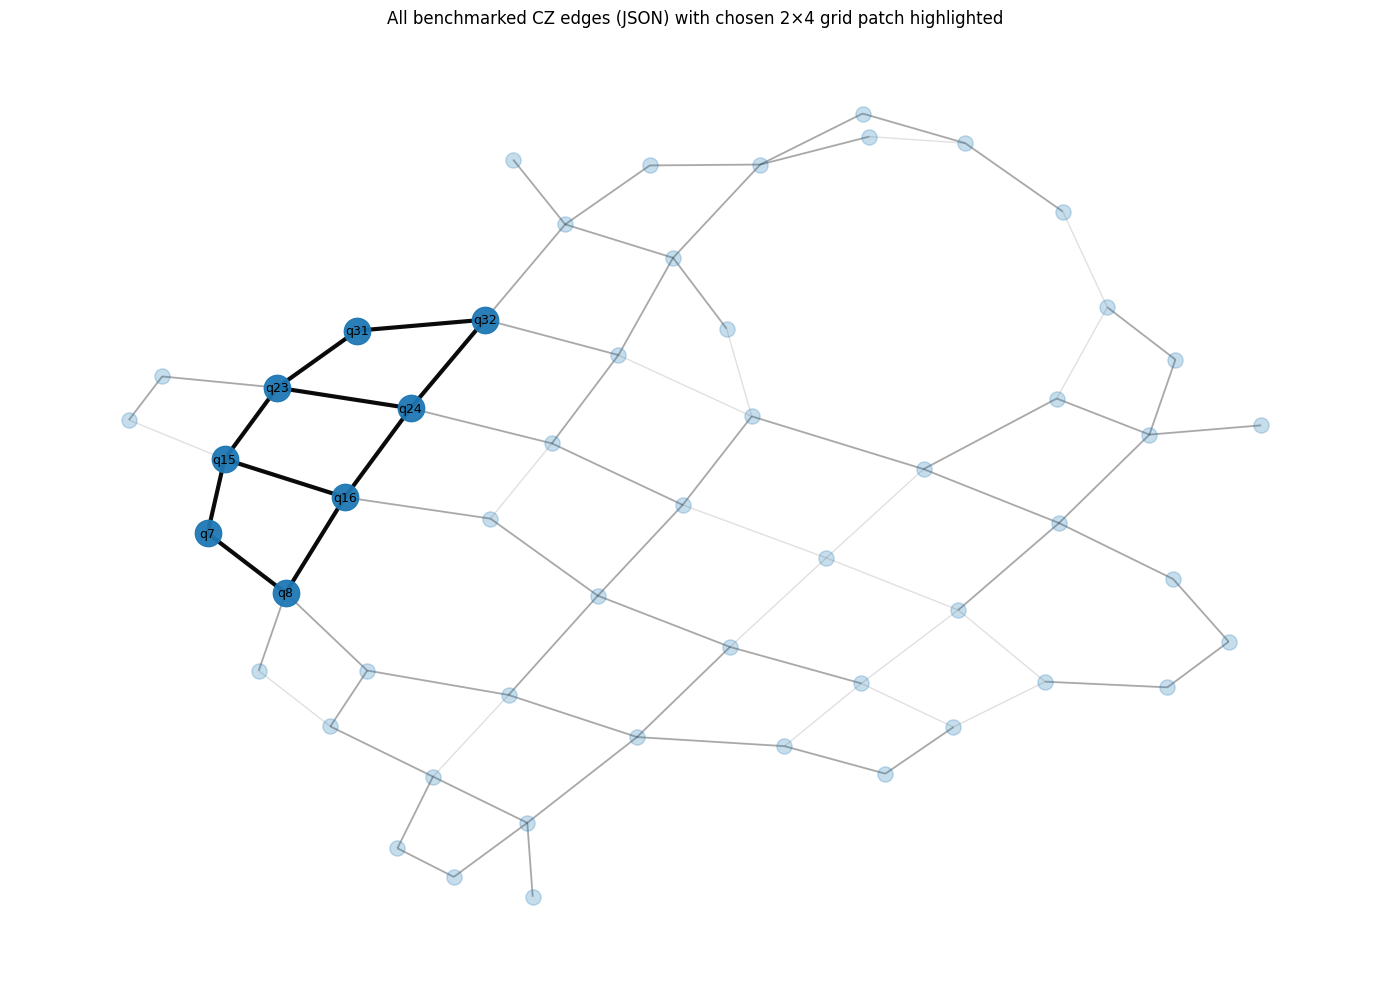

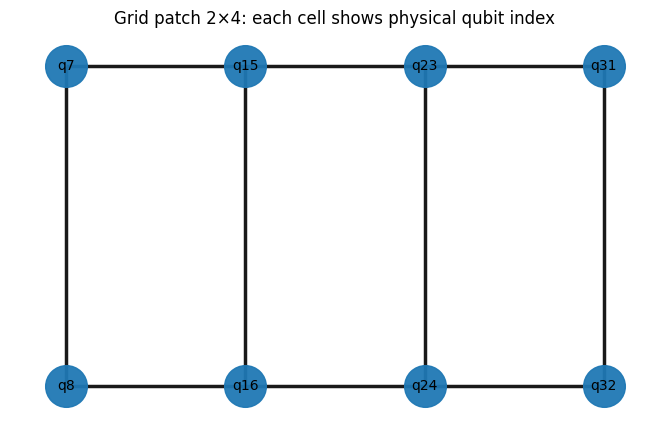


Largest component size in pruned graph: 53 top sizes: [53, 1]
Total pruned edges: 64
Max possible grid size roughly bounded by edges.

✅ Done. You now have:
  GRID_SHAPE: (2, 4)
  COMPONENT  (physical qubit indices): 8
  EDGES      (grid nearest-neighbor edges): 10
  qc_transpiled (Qrisp/Qiskit circuit pinned to those qubits)

=== TRANSPILED CIRCUIT (text) ===
                          
 q.0: ────────────────────
                          
 q.1: ────────────────────
                          
 q.2: ────────────────────
                          
 q.3: ────────────────────
                          
 q.4: ────────────────────
                          
 q.5: ────────────────────
                          
 q.6: ────────────────────
      ┌───┐               
 q.7: ┤ H ├─■──■──────────
      ├───┤ │  │          
 q.8: ┤ H ├─■──┼──■───────
      └───┘    │  │       
 q.9: ─────────┼──┼───────
               │  │       
q.10: ─────────┼──┼───────
               │  │       
q.11: ─────────

In [ ]:
# ============================================================
# ONE-CELL (NO backend needed):
#   JSON -> prune by fidelity -> find largest r×c 2D grid patch
#   -> build 2D cluster (graph) state with Qrisp
#   -> (optional) run on IQM via Qrisp IQMBackend
# ============================================================

# If you need installs in a fresh Colab runtime, uncomment:
# !pip -q install qiskit qrisp networkx

import json, re
from collections import defaultdict, deque
from typing import Dict, List, Set, Tuple, Optional

import networkx as nx
from qiskit.transpiler import CouplingMap
from qrisp import QuantumVariable, h, cz
from qrisp.interface import IQMBackend

import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1) Prompts (click play)
# -----------------------------
BENCH_JSON_PATH = input("Benchmark JSON path (e.g. /mnt/data/your.json): ").strip()
if not BENCH_JSON_PATH:
    raise ValueError("You must enter a benchmark JSON path.")

thr_in = input("Fidelity threshold [default 0.992]: ").strip()
FID_THRESHOLD = float(thr_in) if thr_in else 0.992

missing_policy = input("Missing-edge policy drop/keep [default drop]: ").strip().lower() or "drop"
if missing_policy not in ("drop", "keep"):
    raise ValueError("Missing-edge policy must be 'drop' or 'keep'.")
# NOTE: In this no-backend version, edges come from the JSON itself,
# so 'missing_policy' does not change pruning behavior; we keep it for compatibility.

nq_in = input("Total number of qubits [default infer from JSON or 54]: ").strip()
# If user leaves blank, we'll infer from JSON; if that fails, default to 54.

run_choice = input("Run on IQM now? (y/N) [default N]: ").strip().lower()
RUN_ON_IQM = (run_choice == "y")

if RUN_ON_IQM:
    IQM_RESONANCE_TOKEN = input("IQM Resonance API token: ").strip() or IAqs1Kkei5vUF81rkQfPO6lyl51GDtX5VQWRL4TQEpABnBl8HVh8YpAiDbcN49R8
    IQM_DEVICE_INSTANCE = input("IQM device instance [default emerald]: ").strip() or "emerald"
    SHOTS = int(input("Shots [default 1000]: ").strip() or "1000")

# -----------------------------
# 2) Toolkit: JSON -> fidelities + edge list
# -----------------------------
_QB_RE = re.compile(r"QB(\d+)$")

def qb_to_index(qb: str) -> int:
    m = _QB_RE.match(qb.strip())
    if not m:
        raise ValueError(f"Bad QB name: {qb}")
    return int(m.group(1)) - 1  # QB1 -> 0

def load_edge_fidelities_from_benchmark(json_path: str) -> Dict[Tuple[int,int], float]:
    """
    Parse benchmark JSON into { (u,v) with u<v : fidelity }.

    Looks for:
      - metrics.rb.clifford.uz_cz.QB12__QB13.fidelity...
      - metrics.irb.cz.<something>.QB12__QB13.fidelity...
    If multiple entries exist for same pair, takes max (optimistic, same as your previous code).
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    fid: Dict[Tuple[int,int], float] = {}

    pat_rb  = re.compile(r"metrics\.rb\.clifford\.uz_cz\.(QB\d+)__(QB\d+)\.fidelity\b")
    pat_irb = re.compile(r"metrics\.irb\.cz\..*?\.(QB\d+)__(QB\d+)\.fidelity\b")

    for obs in data.get("observations", []):
        field = obs.get("dut_field", "")
        val = obs.get("value", None)
        if val is None:
            continue
        try:
            v = float(val)
        except Exception:
            continue

        m = pat_rb.search(field)
        if not m:
            m = pat_irb.search(field)
        if not m:
            continue

        a_qb, b_qb = m.group(1), m.group(2)
        a, b = qb_to_index(a_qb), qb_to_index(b_qb)
        u, v2 = (a, b) if a < b else (b, a)
        fid[(u, v2)] = max(fid.get((u, v2), 0.0), v)

    return fid

def infer_num_qubits_from_edges(edges: List[Tuple[int,int]]) -> int:
    if not edges:
        return 0
    mx = max(max(u, v) for (u, v) in edges)
    return mx + 1

# -----------------------------
# 3) Prune edges by fidelity
# -----------------------------
def prune_edges_by_fidelity_from_json(edge_fid: Dict[Tuple[int,int], float], threshold: float) -> Set[Tuple[int,int]]:
    return {e for e, f in edge_fid.items() if f >= threshold}

# -----------------------------
# 4) Find largest r×c grid patch inside pruned graph
# -----------------------------
def build_nx_graph(all_nodes: List[int], kept_edges: Set[Tuple[int,int]]) -> nx.Graph:
    G = nx.Graph()
    G.add_nodes_from(all_nodes)
    G.add_edges_from(list(kept_edges))
    return G

def candidate_grid_shapes(max_nodes: int) -> List[Tuple[int,int,int]]:
    """
    Return candidate (area, r, c) sorted by area desc.
    Only r>=2,c>=2 and r<=c to avoid duplicates.
    """
    cand = []
    for r in range(2, max_nodes + 1):
        for c in range(r, max_nodes + 1):
            area = r * c
            if area > max_nodes:
                break
            cand.append((area, r, c))
    cand.sort(reverse=True)
    return cand

def find_largest_grid_patch(G: nx.Graph, max_shapes: int = 140):
    """
    Find the largest r×c grid graph as a subgraph of G (VF2).
    Returns:
      (r, c, patch_nodes, patch_edges, mapping_grid_to_phys)
    or None if not found.
    """
    n = G.number_of_nodes()
    shapes = candidate_grid_shapes(n)[:max_shapes]

    for area, r, c in shapes:
        H = nx.grid_2d_graph(r, c)  # nodes are (i,j)
        if G.number_of_edges() < H.number_of_edges():
            continue

        GM = nx.algorithms.isomorphism.GraphMatcher(G, H)
        if not GM.subgraph_is_isomorphic():
            continue

        mapping_phys_to_grid = next(GM.subgraph_isomorphisms_iter())
        mapping_grid_to_phys = {grid: phys for phys, grid in mapping_phys_to_grid.items()}

        patch_nodes = sorted(mapping_grid_to_phys.values())

        # Only nearest-neighbor edges of the grid
        patch_edges = []
        for (gu, gv) in H.edges():
            pu = mapping_grid_to_phys[gu]
            pv = mapping_grid_to_phys[gv]
            u, v2 = (pu, pv) if pu < pv else (pv, pu)
            patch_edges.append((u, v2))
        patch_edges = sorted(set(patch_edges))

        return r, c, patch_nodes, patch_edges, mapping_grid_to_phys

    return None

# -----------------------------
# 5) CouplingMap restricted to chosen patch (for transpile)
# -----------------------------
def reduced_couplingmap_for_component(component_nodes: List[int], component_edges: List[Tuple[int,int]]) -> CouplingMap:
    directed = []
    for u, v in component_edges:
        directed.append((u, v))
        directed.append((v, u))

    cm = CouplingMap(couplinglist=directed)

    # Add nodes only if missing (avoids CouplingError)
    for q in component_nodes:
        if q not in cm.physical_qubits:
            cm.add_physical_qubit(q)

    return cm

# -----------------------------
# 6) Build Qrisp 2D cluster (graph) state on the patch
# -----------------------------
def build_qrisp_graph_state(component_nodes: List[int], component_edges: List[Tuple[int,int]]) -> QuantumVariable:
    n = len(component_nodes)
    qv = QuantumVariable(n)

    # |+>^n
    for i in range(n):
        h(qv[i])

    # CZ on patch edges (physical -> logical mapping)
    phys_to_log = {q: i for i, q in enumerate(component_nodes)}
    for (u, v) in component_edges:
        cz(qv[phys_to_log[u]], qv[phys_to_log[v]])

    return qv

# -----------------------------
# 7) Diagnostics: connected components in pruned graph
# -----------------------------
def component_sizes_from_edges(all_nodes: List[int], kept_edges: Set[Tuple[int,int]]) -> List[int]:
    adj = defaultdict(set)
    for u, v in kept_edges:
        adj[u].add(v)
        adj[v].add(u)

    unvisited = set(all_nodes)
    sizes = []
    while unvisited:
        s = next(iter(unvisited))
        q = deque([s])
        unvisited.remove(s)
        comp = {s}
        while q:
            x = q.popleft()
            for y in adj.get(x, ()):
                if y in unvisited:
                    unvisited.remove(y)
                    comp.add(y)
                    q.append(y)
        sizes.append(len(comp))
    sizes.sort(reverse=True)
    return sizes

# -----------------------------
# 8) Run: JSON -> prune -> grid patch -> circuit
# -----------------------------
edge_fid = load_edge_fidelities_from_benchmark(BENCH_JSON_PATH)
print(f"\nLoaded fidelities for {len(edge_fid)} undirected edges (from JSON)")

all_edges = list(edge_fid.keys())

# Determine total qubits
if nq_in:
    N_QUBITS = int(nq_in)
else:
    N_QUBITS = infer_num_qubits_from_edges(all_edges) or 54

all_nodes = list(range(N_QUBITS))

kept_edges = prune_edges_by_fidelity_from_json(edge_fid, FID_THRESHOLD)
print(f"Kept {len(kept_edges)} undirected edges at threshold={FID_THRESHOLD} (missing_policy={missing_policy})")

G = build_nx_graph(all_nodes, kept_edges)

grid_result = find_largest_grid_patch(G, max_shapes=140)
if grid_result is None:
    sizes = component_sizes_from_edges(all_nodes, kept_edges)
    raise RuntimeError(
        "No r×c grid patch found in the pruned graph at this threshold.\n"
        "Try lowering the threshold (e.g. 0.99 or 0.985).\n"
        f"FYI: largest component size in pruned graph = {sizes[0] if sizes else 0}"
    )

r, c, component_nodes, component_edges, mapping_grid_to_phys = grid_result

print("\n✅ Largest grid patch found:")
print(f"  shape: {r} x {c} (area={r*c})")
print(f"  qubits used: {len(component_nodes)}")
print(f"  grid edges used: {len(component_edges)} (expected {(r-1)*c + r*(c-1)})")
print("  first 15 qubits:", component_nodes[:15])
print("  first 15 edges :", component_edges[:15])

# sanity: ensure all patch edges are present in kept_edges
missing = [e for e in component_edges if e not in kept_edges]
print(f"  missing patch edges in kept_edges: {len(missing)}")
if missing:
    print("  first missing:", missing[:10])

# store for reuse (same names as before)
COMPONENT = component_nodes
EDGES = component_edges
GRID_SHAPE = (r, c)

# Build Qrisp program (2D cluster = grid graph state)
qv = build_qrisp_graph_state(COMPONENT, EDGES)

# Compile + transpile pinned to physical qubits and restricted coupling
qc_qrisp = qv.qs.compile()
reduced_cm = reduced_couplingmap_for_component(COMPONENT, EDGES)

qc_transpiled = qc_qrisp.transpile(
    coupling_map=reduced_cm,
    initial_layout=COMPONENT,   # logical i -> physical COMPONENT[i]
    optimization_level=1
)

print("\nBuilt 2D grid-cluster (graph) state circuit.")
print("  transpiled depth:", qc_transpiled.depth())
print("  ops:", len(qc_transpiled.data))

COMPONENT = component_nodes
EDGES = component_edges
GRID_SHAPE = (r, c)

# -----------------------------
# 9) Visualization: all qubits/edges + highlight chosen grid patch
# -----------------------------
def visualize_hardware_and_patch(
    all_nodes: List[int],
    all_edges: List[Tuple[int, int]],
    kept_edges: Set[Tuple[int, int]],
    component_nodes: List[int],
    component_edges: List[Tuple[int, int]],
    grid_shape: Tuple[int, int],
    mapping_grid_to_phys: Dict[Tuple[int, int], int],
    show_kept_edges: bool = True,
    label_patch_nodes: bool = True,
):
    """
    Draws:
      - Background: all nodes and all (u,v) edges found in the JSON (possible CZ pairs w/ benchmarks)
      - Optional mid-layer: pruned/kept edges (>= threshold)
      - Highlight: chosen patch nodes + patch edges (grid nearest-neighbor CZs)
    Also draws a second figure: the r×c grid with each cell labeled by its physical qubit index.
    """

    # --- Build graphs ---
    G_all = nx.Graph()
    G_all.add_nodes_from(all_nodes)
    G_all.add_edges_from(all_edges)

    comp_set = set(component_nodes)
    patch_edge_set = set(component_edges)
    kept_edge_set = set(kept_edges)

    # --- Layout ---
    # Spring layout is generic but works without chip coordinates.
    # Seed makes the picture stable across runs.
    n = max(1, len(all_nodes))
    k = 1.2 / np.sqrt(n)  # heuristic spacing
    pos = nx.spring_layout(G_all, seed=7, k=k, iterations=200)

    # --- Figure 1: hardware graph with patch highlighted ---
    plt.figure(figsize=(14, 10))
    plt.title(f"All benchmarked CZ edges (JSON) with chosen {grid_shape[0]}×{grid_shape[1]} grid patch highlighted")

    # Background edges: all JSON edges (very light)
    nx.draw_networkx_edges(
        G_all, pos,
        edgelist=all_edges,
        width=1.0,
        alpha=0.12
    )

    # Optional: kept/pruned edges (a bit darker)
    if show_kept_edges:
        nx.draw_networkx_edges(
            G_all, pos,
            edgelist=list(kept_edge_set),
            width=1.4,
            alpha=0.25
        )

    # Patch edges: bold
    nx.draw_networkx_edges(
        G_all, pos,
        edgelist=list(patch_edge_set),
        width=3.0,
        alpha=0.95
    )

    # Nodes: non-patch small + transparent
    nonpatch_nodes = [u for u in all_nodes if u not in comp_set]
    nx.draw_networkx_nodes(
        G_all, pos,
        nodelist=nonpatch_nodes,
        node_size=120,
        alpha=0.25
    )

    # Patch nodes: larger
    nx.draw_networkx_nodes(
        G_all, pos,
        nodelist=list(comp_set),
        node_size=360,
        alpha=0.95
    )

    # Labels (optional): label only patch nodes so it stays readable
    if label_patch_nodes:
        labels = {u: f"q{u}" for u in comp_set}
        nx.draw_networkx_labels(G_all, pos, labels=labels, font_size=9)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- Figure 2: grid view (r×c) with physical qubit labels ---
    r, c = grid_shape
    plt.figure(figsize=(1.2*c + 2, 1.2*r + 2))
    plt.title(f"Grid patch {r}×{c}: each cell shows physical qubit index")

    # Build a grid graph for visualization
    H = nx.grid_2d_graph(r, c)

    # Place nodes on a literal grid so it looks like a lattice
    pos_grid = {(i, j): (j, -i) for (i, j) in H.nodes()}  # x=j, y=-i

    # Draw edges (all are patch edges by construction)
    nx.draw_networkx_edges(H, pos_grid, width=2.5, alpha=0.9)

    # Draw nodes
    nx.draw_networkx_nodes(H, pos_grid, node_size=900, alpha=0.95)

    # Label each grid coordinate with its mapped physical qubit
    grid_labels = {g: f"q{mapping_grid_to_phys[g]}" for g in H.nodes()}
    nx.draw_networkx_labels(H, pos_grid, labels=grid_labels, font_size=10)

    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Call the visualization right after you set COMPONENT/EDGES/GRID_SHAPE
visualize_hardware_and_patch(
    all_nodes=all_nodes,
    all_edges=all_edges,          # all benchmarked CZ edges found in the JSON
    kept_edges=kept_edges,        # edges surviving the fidelity threshold
    component_nodes=COMPONENT,    # chosen physical qubits
    component_edges=EDGES,        # chosen CZs (grid nearest-neighbors)
    grid_shape=GRID_SHAPE,
    mapping_grid_to_phys=mapping_grid_to_phys,
    show_kept_edges=True,
    label_patch_nodes=True
)

# Optional run on IQM (Qrisp backend)
if RUN_ON_IQM:
    iqm_backend = IQMBackend(api_token=IQM_RESONANCE_TOKEN, device_instance=IQM_DEVICE_INSTANCE)
    res = qv.get_measurement(
        backend=iqm_backend,
        shots=SHOTS,
        compile=False,
        precompiled_qc=qc_transpiled
    )
    print("\nExecution complete. Measurement results:", res)

# Print component sizes (diagnostic parity with previous script)
sizes = component_sizes_from_edges(all_nodes, kept_edges)
print("\nLargest component size in pruned graph:", sizes[0] if sizes else 0, "top sizes:", sizes[:5])
print("Total pruned edges:", len(kept_edges))
print("Max possible grid size roughly bounded by edges.")

print("\n✅ Done. You now have:")
print("  GRID_SHAPE:", GRID_SHAPE)
print("  COMPONENT  (physical qubit indices):", len(COMPONENT))
print("  EDGES      (grid nearest-neighbor edges):", len(EDGES))
print("  qc_transpiled (Qrisp/Qiskit circuit pinned to those qubits)")

print("\n=== TRANSPILED CIRCUIT (text) ===")
print(qc_transpiled)

print("\n=== TRANSPILED CIRCUIT (instructions) ===")
for inst in qc_transpiled.data:
    print(inst)



Fidelity threshold [default 0.992]: 0.994
Missing-edge policy drop/keep [default drop] (note: ignored here): 
Max chain length (qubits) [default no cap]: 
Duplicate-edge policy [max/min/rb_first, default max]: 

(Info) No IQM token needed: graph connectivity is inferred from the JSON qubit-pairs.

Loaded fidelities for 81 undirected edges (from JSON)
Inferred 54 qubits present in JSON (min=0, max=53)
Kept 40 undirected edges at threshold=0.994
Largest component size in pruned graph: 16 top sizes: [16, 12, 8, 4, 2]

✅ Largest 1D chain patch found:
  chain length (qubits): 12
  chain edges used     : 11 (expected 11)
  extra edges among chain nodes (chords): 0
  first 20 qubits: [2, 3, 4, 5, 11, 10, 18, 17, 16, 15, 14, 22]
  first 20 edges : [(2, 3), (3, 4), (4, 5), (5, 11), (10, 11), (10, 18), (17, 18), (16, 17), (15, 16), (14, 15), (14, 22)]

Built 1D chain-cluster (graph) state circuit.
  transpiled depth: 3
  ops: 23

✅ Done. You now have:
  CHAIN_LENGTH: 12
  COMPONENT (physical qub

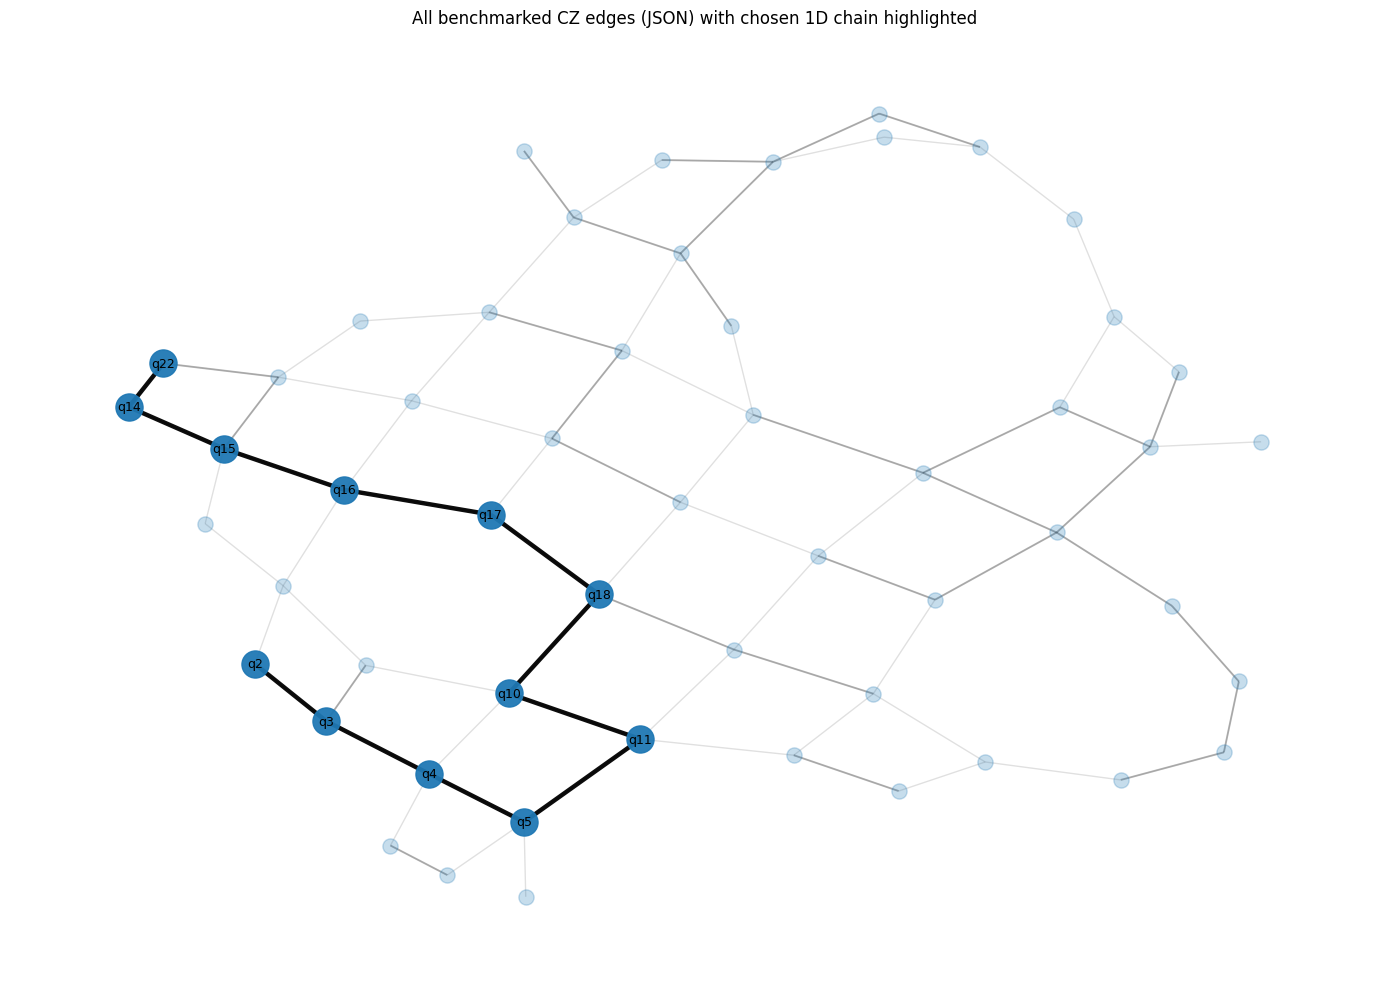

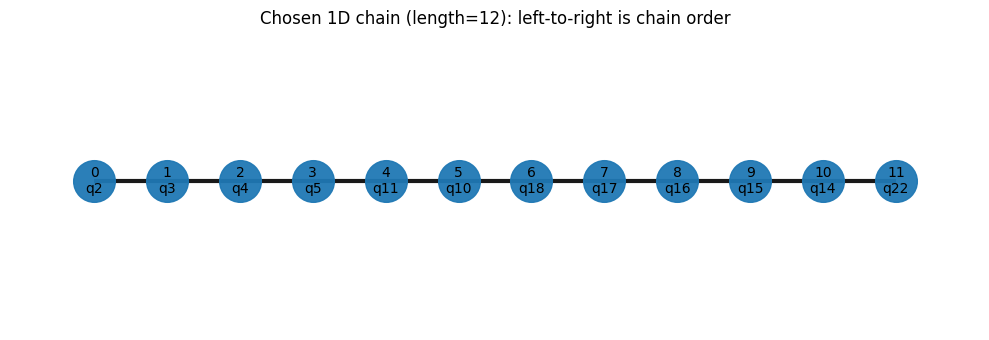

In [ ]:
# @title
# ============================================================
# ONE-CELL (NO IQM TOKEN): JSON -> prune -> largest 1D chain -> build 1D cluster (graph) state
#   - No backend needed
#   - Connectivity inferred from benchmark JSON pairs (QB#__QB#)
# ============================================================

import json, re
from typing import Dict, List, Set, Tuple, Optional
from collections import defaultdict

import networkx as nx
from qiskit.transpiler import CouplingMap
from qrisp import QuantumVariable, h, cz

import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1) Prompts (click play)
# -----------------------------
BENCH_JSON_PATH = "/mnt/data/2026-02-01T07_18_34.853378Z (1).json"
if not BENCH_JSON_PATH:
    raise ValueError("You must enter a benchmark JSON path.")

thr_in = input("Fidelity threshold [default 0.992]: ").strip()
FID_THRESHOLD = float(thr_in) if thr_in else 0.992

# This is kept for UI parity with your earlier cells, but without a hardware coupling map,
# "missing edges" don't exist beyond what appears in the JSON.
missing_policy = input("Missing-edge policy drop/keep [default drop] (note: ignored here): ").strip().lower() or "drop"
if missing_policy not in ("drop", "keep"):
    raise ValueError("Missing-edge policy must be 'drop' or 'keep'.")

cap_in = input("Max chain length (qubits) [default no cap]: ").strip()
MAX_CHAIN_LEN = int(cap_in) if cap_in else None

# How to combine RB and IRB fidelities if both appear
dup_policy = input("Duplicate-edge policy [max/min/rb_first, default max]: ").strip().lower() or "max"
if dup_policy not in ("max", "min", "rb_first"):
    raise ValueError("Duplicate-edge policy must be one of: max, min, rb_first.")

print("\n(Info) No IQM token needed: graph connectivity is inferred from the JSON qubit-pairs.\n")

# -----------------------------
# 2) Helpers: QB naming/parsing
# -----------------------------
def qb_to_index(qb: str) -> int:
    """QB12 -> 11"""
    m = re.fullmatch(r"QB(\d+)", qb.strip())
    if not m:
        raise ValueError(f"Bad qubit name: {qb}")
    return int(m.group(1)) - 1

def undirected(u: int, v: int) -> Tuple[int, int]:
    return (u, v) if u < v else (v, u)

# -----------------------------
# 3) Load edge fidelities from JSON
# -----------------------------
def load_edge_fidelities_from_benchmark(json_path: str, duplicate_policy: str = "max") -> Dict[Tuple[int,int], float]:
    """
    Parse benchmark JSON into {(u,v): fidelity} with u<v (physical indices inferred as QB#-1).

    Looks for:
      - metrics.rb.clifford.uz_cz.QB12__QB13.fidelity...
      - metrics.irb.cz.<anything>.QB12__QB13.fidelity...

    duplicate_policy:
      - "max" (optimistic)
      - "min" (conservative)
      - "rb_first" (use RB if present, else IRB)
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    # Patterns
    pat_rb  = re.compile(r"metrics\.rb\.clifford\.uz_cz\.(QB\d+)__(QB\d+)\.fidelity\b")
    pat_irb = re.compile(r"metrics\.irb\.cz\..*?\.(QB\d+)__(QB\d+)\.fidelity\b")

    fid: Dict[Tuple[int,int], float] = {}
    rb_seen: Set[Tuple[int,int]] = set()

    for obs in data.get("observations", []):
        field = obs.get("dut_field", "")
        val = obs.get("value", None)
        if val is None:
            continue
        try:
            v = float(val)
        except Exception:
            continue

        m = pat_rb.search(field)
        if m:
            u = qb_to_index(m.group(1))
            vq = qb_to_index(m.group(2))
            e = undirected(u, vq)
            rb_seen.add(e)
            if duplicate_policy == "min":
                fid[e] = min(fid.get(e, v), v)
            else:
                fid[e] = max(fid.get(e, 0.0), v)
            continue

        m = pat_irb.search(field)
        if m:
            u = qb_to_index(m.group(1))
            vq = qb_to_index(m.group(2))
            e = undirected(u, vq)

            if duplicate_policy == "rb_first" and e in rb_seen:
                continue

            if duplicate_policy == "min":
                fid[e] = min(fid.get(e, v), v)
            else:
                fid[e] = max(fid.get(e, 0.0), v)
            continue

    return fid

edge_fid = load_edge_fidelities_from_benchmark(BENCH_JSON_PATH, duplicate_policy=dup_policy)
if not edge_fid:
    raise RuntimeError("No CZ-like fidelities parsed from JSON. Check the JSON format and regex patterns.")

print(f"Loaded fidelities for {len(edge_fid)} undirected edges (from JSON)")

# Infer node set from all qubits ever mentioned in the JSON edges
all_nodes_set: Set[int] = set()
for (u, v) in edge_fid.keys():
    all_nodes_set.add(u)
    all_nodes_set.add(v)
all_nodes = sorted(all_nodes_set)

print(f"Inferred {len(all_nodes)} qubits present in JSON (min={min(all_nodes)}, max={max(all_nodes)})")

# -----------------------------
# 4) Prune edges by threshold
# -----------------------------
kept_edges = {e for e, f in edge_fid.items() if f >= FID_THRESHOLD}
print(f"Kept {len(kept_edges)} undirected edges at threshold={FID_THRESHOLD}")

G = nx.Graph()
G.add_nodes_from(all_nodes)
G.add_edges_from(list(kept_edges))

comp_sizes = sorted([len(c) for c in nx.connected_components(G)], reverse=True)
print("Largest component size in pruned graph:", (comp_sizes[0] if comp_sizes else 0), "top sizes:", comp_sizes[:5])

if not kept_edges or not comp_sizes or comp_sizes[0] < 2:
    raise RuntimeError(
        "After pruning, no non-trivial connectivity remains.\n"
        "Try lowering threshold (e.g. 0.99) or verify the JSON contains the couplers you expect."
    )

# -----------------------------
# 5) Find largest 1D chain patch (diameter path) in the largest component
# -----------------------------
def find_diameter_path_in_component(Gc: nx.Graph) -> List[int]:
    best_u = None
    best_v = None
    best_d = -1
    for u, dist_map in nx.all_pairs_shortest_path_length(Gc):
        v, d = max(dist_map.items(), key=lambda x: x[1])
        if d > best_d:
            best_d = d
            best_u = u
            best_v = v
    if best_u is None or best_v is None:
        return []
    return nx.shortest_path(Gc, source=best_u, target=best_v)

largest_comp = max(nx.connected_components(G), key=len)
Gc = G.subgraph(largest_comp).copy()
path_nodes = find_diameter_path_in_component(Gc)

if MAX_CHAIN_LEN is not None and len(path_nodes) > MAX_CHAIN_LEN:
    path_nodes = path_nodes[:MAX_CHAIN_LEN]

if len(path_nodes) < 2:
    raise RuntimeError("Could not find a non-trivial chain path in the pruned graph.")

path_edges = [undirected(path_nodes[i], path_nodes[i+1]) for i in range(len(path_nodes)-1)]

# Sanity: ensure all chain edges exist in kept_edges
missing = [e for e in path_edges if e not in kept_edges]
if missing:
    raise RuntimeError(f"Internal error: chain edges missing from kept_edges: {missing[:10]}")

# Diagnostics: extra edges among chosen nodes (chords)
subG = G.subgraph(path_nodes)
extra_edges = subG.number_of_edges() - len(path_edges)

print("\n✅ Largest 1D chain patch found:")
print(f"  chain length (qubits): {len(path_nodes)}")
print(f"  chain edges used     : {len(path_edges)} (expected {len(path_nodes)-1})")
print(f"  extra edges among chain nodes (chords): {extra_edges}")
print("  first 20 qubits:", path_nodes[:20])
print("  first 20 edges :", path_edges[:20])

# Store for reuse
COMPONENT = list(path_nodes)   # physical qubit indices in chain order
EDGES = list(path_edges)       # undirected consecutive edges
CHAIN_LENGTH = len(COMPONENT)

# -----------------------------
# 6) Build CouplingMap restricted to chosen chain
# -----------------------------
def reduced_couplingmap_for_component(component_nodes: List[int], component_edges: List[Tuple[int,int]]) -> CouplingMap:
    directed = []
    for u, v in component_edges:
        directed.append((u, v))
        directed.append((v, u))

    cm = CouplingMap(couplinglist=directed)

    # Add nodes only if missing (avoids CouplingError)
    for q in component_nodes:
        if q not in cm.physical_qubits:
            cm.add_physical_qubit(q)
    return cm

# -----------------------------
# 7) Build Qrisp 1D cluster (path-graph) state
# -----------------------------
def build_qrisp_graph_state(component_nodes: List[int], component_edges: List[Tuple[int,int]]) -> QuantumVariable:
    n = len(component_nodes)
    qv = QuantumVariable(n)

    # |+>^n
    for i in range(n):
        h(qv[i])

    # CZ only along chain edges
    phys_to_log = {q: i for i, q in enumerate(component_nodes)}
    for (u, v) in component_edges:
        cz(qv[phys_to_log[u]], qv[phys_to_log[v]])

    return qv

qv = build_qrisp_graph_state(COMPONENT, EDGES)

# Compile + transpile pinned to "physical" qubit indices with restricted coupling map
qc_qrisp = qv.qs.compile()
reduced_cm = reduced_couplingmap_for_component(COMPONENT, EDGES)

qc_transpiled = qc_qrisp.transpile(
    coupling_map=reduced_cm,
    initial_layout=COMPONENT,   # logical i -> physical COMPONENT[i]
    optimization_level=1
)

print("\nBuilt 1D chain-cluster (graph) state circuit.")
print("  transpiled depth:", qc_transpiled.depth())
print("  ops:", len(qc_transpiled.data))

print("\n✅ Done. You now have:")
print("  CHAIN_LENGTH:", CHAIN_LENGTH)
print("  COMPONENT (physical qubit indices, in chain order):", len(COMPONENT))
print("  EDGES     (consecutive chain edges):", len(EDGES))
print("  qc_transpiled (Qrisp circuit pinned to those qubits)")

print("\n=== TRANSPILED CIRCUIT (text) ===")
print(qc_transpiled)

print("\n=== TRANSPILED CIRCUIT (instructions) ===")
for inst in qc_transpiled.data:
    print(inst)

# -----------------------------
# 8) Visualization: all qubits/edges + highlight chosen 1D chain patch
# -----------------------------
def visualize_hardware_and_chain(
    all_nodes: List[int],
    all_edges: List[Tuple[int, int]],
    kept_edges: Set[Tuple[int, int]],
    chain_nodes: List[int],                 # in chain order
    chain_edges: List[Tuple[int, int]],     # consecutive undirected edges
    show_kept_edges: bool = True,
    label_chain_nodes: bool = True,
    show_chords_among_chain_nodes: bool = True,
):
    """
    Draws:
      - Background: all nodes and all JSON edges (benchmarked CZ pairs)
      - Optional mid-layer: kept/pruned edges (>= threshold)
      - Highlight: chosen chain nodes + chain edges (consecutive CZs)
      - Optional: chords among chain nodes (kept edges between chain nodes that are NOT chain edges)

    Also draws a second figure: a linear chain (left-to-right) in the chain order,
    with nodes labeled by physical qubit index.
    """

    # --- Build graphs ---
    G_all = nx.Graph()
    G_all.add_nodes_from(all_nodes)
    G_all.add_edges_from(all_edges)

    chain_set = set(chain_nodes)
    chain_edge_set = set(chain_edges)
    kept_edge_set = set(kept_edges)

    # --- Layout (generic; no physical coordinates available) ---
    n = max(1, len(all_nodes))
    k = 1.2 / np.sqrt(n)  # heuristic spacing
    pos = nx.spring_layout(G_all, seed=7, k=k, iterations=200)

    # --- Compute chords among chosen chain nodes (if desired) ---
    chord_edges = []
    if show_chords_among_chain_nodes:
        # consider only kept edges internal to chain nodes
        internal_kept = [
            e for e in kept_edge_set
            if (e[0] in chain_set and e[1] in chain_set)
        ]
        # chords = internal kept edges that are not consecutive chain edges
        chord_edges = [e for e in internal_kept if e not in chain_edge_set]

    # --- Figure 1: whole hardware graph with chain highlighted ---
    plt.figure(figsize=(14, 10))
    plt.title("All benchmarked CZ edges (JSON) with chosen 1D chain highlighted")

    # Background edges: all JSON edges (very light)
    nx.draw_networkx_edges(
        G_all, pos,
        edgelist=all_edges,
        width=1.0,
        alpha=0.12
    )

    # Optional: kept/pruned edges (a bit darker)
    if show_kept_edges:
        nx.draw_networkx_edges(
            G_all, pos,
            edgelist=list(kept_edge_set),
            width=1.4,
            alpha=0.25
        )

    # Optional: chords among chain nodes (distinct emphasis)
    if chord_edges:
        nx.draw_networkx_edges(
            G_all, pos,
            edgelist=chord_edges,
            width=2.2,
            alpha=0.55
        )

    # Chain edges: boldest
    nx.draw_networkx_edges(
        G_all, pos,
        edgelist=list(chain_edge_set),
        width=3.2,
        alpha=0.95
    )

    # Nodes: non-chain smaller + transparent
    nonchain_nodes = [u for u in all_nodes if u not in chain_set]
    nx.draw_networkx_nodes(
        G_all, pos,
        nodelist=nonchain_nodes,
        node_size=120,
        alpha=0.25
    )

    # Chain nodes: larger
    nx.draw_networkx_nodes(
        G_all, pos,
        nodelist=list(chain_set),
        node_size=380,
        alpha=0.95
    )

    # Labels (optional): label only chain nodes so it stays readable
    if label_chain_nodes:
        labels = {u: f"q{u}" for u in chain_nodes}
        nx.draw_networkx_labels(G_all, pos, labels=labels, font_size=9)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- Figure 2: linear chain view (in chain order) ---
    plt.figure(figsize=(max(10, 0.55 * len(chain_nodes)), 3.5))
    plt.title(f"Chosen 1D chain (length={len(chain_nodes)}): left-to-right is chain order")

    # Build a path graph in *order* 0..L-1, then label by physical qubit index
    L = len(chain_nodes)
    P = nx.path_graph(L)

    # Place on a line: x=i, y=0
    pos_line = {i: (i, 0.0) for i in range(L)}

    # Draw edges/nodes
    nx.draw_networkx_edges(P, pos_line, width=3.0, alpha=0.9)
    nx.draw_networkx_nodes(P, pos_line, node_size=900, alpha=0.95)

    # Labels: physical qubit index and also chain position
    line_labels = {i: f"{i}\nq{chain_nodes[i]}" for i in range(L)}
    nx.draw_networkx_labels(P, pos_line, labels=line_labels, font_size=10)

    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Call it (right after COMPONENT/EDGES/CHAIN_LENGTH are set)
all_edges = list(edge_fid.keys())  # benchmarked CZ pairs extracted from JSON
visualize_hardware_and_chain(
    all_nodes=all_nodes,
    all_edges=all_edges,
    kept_edges=kept_edges,
    chain_nodes=COMPONENT,  # in chain order
    chain_edges=EDGES,
    show_kept_edges=True,
    label_chain_nodes=True,
    show_chords_among_chain_nodes=True
)



In [ ]:
# @title
# ============================================================
# Qrisp-native: run 2-setting graph-state witness on IQM
# FIXED bit order: LEFTMOST bit is logical qubit 0
# ============================================================

from collections import defaultdict, deque
from typing import Dict, List, Set, Tuple

from qrisp import QuantumVariable, h, cz
from qrisp.interface import IQMBackend


# ---------- 1) Graph helpers ----------
def build_adj(edges: List[Tuple[int, int]]) -> Dict[int, Set[int]]:
    adj = defaultdict(set)
    for u, v in edges:
        adj[u].add(v)
        adj[v].add(u)
    return adj


def bipartite_2coloring(nodes: List[int], edges: List[Tuple[int, int]]) -> Tuple[Set[int], Set[int]]:
    """Return (color0, color1) sets for the induced subgraph; raises if not bipartite."""
    adj = build_adj(edges)
    color: Dict[int, int] = {}

    for start in nodes:
        if start in color:
            continue
        color[start] = 0
        q = deque([start])

        while q:
            v = q.popleft()
            for u in adj.get(v, ()):
                if u not in color:
                    color[u] = 1 - color[v]
                    q.append(u)
                elif color[u] == color[v]:
                    raise ValueError("Patch graph is NOT bipartite; 2-color witness setting not valid.")

    c0 = {n for n in nodes if color[n] == 0}
    c1 = set(nodes) - c0
    return c0, c1


def eigenval_from_bit(b: int) -> int:
    """Map measured bit (0/1) to Pauli eigenvalue (+1/-1)."""
    return 1 if b == 0 else -1


# ---------- 2) Build graph/cluster state as Qrisp program ----------
def build_qrisp_graph_state(
    component_nodes: List[int],
    component_edges: List[Tuple[int, int]],
) -> Tuple[QuantumVariable, Dict[int, int]]:
    """
    Returns (qv, phys_to_log).
    qv is a QuantumVariable of size len(component_nodes), logical indices 0..n-1.
    """
    n = len(component_nodes)
    qv = QuantumVariable(n)
    phys_to_log = {phys: i for i, phys in enumerate(component_nodes)}

    # |+>^n
    for i in range(n):
        h(qv[i])

    # CZ on edges
    for (u, v) in component_edges:
        cz(qv[phys_to_log[u]], qv[phys_to_log[v]])

    return qv, phys_to_log


# ---------- 3) Parse Qrisp measurement output into counts ----------
def normalize_qrisp_measurement(res, shots: int) -> Dict[str, int]:
    """
    Qrisp can return:
      - dict(bitstring -> counts) OR
      - dict(bitstring -> probs)
    Convert to counts.
    """
    if not isinstance(res, dict) or len(res) == 0:
        raise RuntimeError("Unexpected/empty measurement result from Qrisp backend.")

    vals = list(res.values())
    # already ints?
    if all(isinstance(v, int) for v in vals):
        return dict(res)

    # probs?
    s = float(sum(float(v) for v in vals))
    if 0.9 <= s <= 1.1:
        return {k: int(round(float(v) * shots)) for k, v in res.items()}

    # fallback: treat as counts-like floats
    return {k: int(round(float(v))) for k, v in res.items()}


# ---------- 4) Bit order (FIXED) ----------
BIT_ORDER = "leftmost_is_q0"

def bit_at_leftmost_is_q0(bitstring: str, logical_index: int) -> int:
    """
    FIXED convention:
      - LEFTMOST bit corresponds to logical qubit 0
      - bitstring[0] -> q0, bitstring[1] -> q1, ...
    """
    if logical_index < 0 or logical_index >= len(bitstring):
        raise IndexError(f"logical_index={logical_index} out of range for bitstring length {len(bitstring)}")
    return 1 if bitstring[logical_index] == "1" else 0


def assert_bitstrings_well_formed(counts: Dict[str, int], n: int) -> None:
    """Basic sanity checks to catch silent bit-order / formatting issues."""
    for s in counts.keys():
        if not isinstance(s, str):
            raise TypeError(f"Expected bitstring keys to be str; got {type(s)}")
        if len(s) != n:
            raise ValueError(
                f"Bitstring length mismatch: expected length {n}, got {len(s)} for bitstring '{s}'. "
                "This usually means the backend returned a different number of measured bits."
            )
        if any(ch not in "01" for ch in s):
            raise ValueError(f"Non-binary bitstring key '{s}' found in counts.")


# ---------- 5) Estimate P(colorclass) from shot data ----------
def estimate_P_from_counts(
    counts: Dict[str, int],
    shots: int,
    color_class_phys: Set[int],
    component_nodes: List[int],
    phys_to_log: Dict[int, int],
    adj_phys: Dict[int, Set[int]],
) -> float:
    """
    Estimate <P_l> = E[ Π_{i in V_l} (1 + s_i)/2 ], where
      s_i = x_i * Π_{j in N(i)} z_j
    using a single measurement setting:
      - X measured on the color class (implemented by H then Z-measure)
      - Z measured on others
    """
    n = len(component_nodes)
    assert_bitstrings_well_formed(counts, n)

    total = 0.0
    used = 0

    for bitstring, c in counts.items():

        def b(log_i: int) -> int:
            # LEFTMOST is q0
            return bit_at_leftmost_is_q0(bitstring, log_i)

        p_val = 1

        for i_phys in color_class_phys:
            i_log = phys_to_log[i_phys]

            # X eigenvalue from measured bit on i (since we applied H for X-measurement)
            x_i = eigenval_from_bit(b(i_log))

            # Multiply Z eigenvalues of neighbors
            prod = 1
            for j_phys in adj_phys[i_phys]:
                j_log = phys_to_log[j_phys]
                z_j = eigenval_from_bit(b(j_log))
                prod *= z_j

            s_i = x_i * prod
            term = (1 + s_i) // 2  # 1 if +1 else 0
            p_val *= term
            if p_val == 0:
                break

        total += p_val * c
        used += c

    return total / max(1, used)


# ---------- 6) Run the two settings on IQM ----------
def run_two_setting_witness_on_iqm(
    component_nodes: List[int],
    component_edges: List[Tuple[int, int]],
    shots: int,
    api_token: str,
    device_instance: str = "emerald",
):
    # 2-coloring of the PATCH GRAPH (physical indices)
    c0_phys, c1_phys = bipartite_2coloring(component_nodes, component_edges)
    adj_phys = build_adj(component_edges)

    # Setting A: measure X on c0 (apply H before measure), Z on others
    qvA, phys_to_logA = build_qrisp_graph_state(component_nodes, component_edges)
    for q_phys in c0_phys:
        h(qvA[phys_to_logA[q_phys]])

    # Setting B: measure X on c1
    qvB, phys_to_logB = build_qrisp_graph_state(component_nodes, component_edges)
    for q_phys in c1_phys:
        h(qvB[phys_to_logB[q_phys]])

    # Run on IQM
    backend_iqm = IQMBackend(api_token=api_token, device_instance=device)

    print("Running setting A (X on color0)...")
    resA = qvA.get_measurement(backend=backend_iqm, shots=shots)
    countsA = normalize_qrisp_measurement(resA, shots)

    print("Running setting B (X on color1)...")
    resB = qvB.get_measurement(backend=backend_iqm, shots=shots)
    countsB = normalize_qrisp_measurement(resB, shots)

    # Estimate <P1>, <P2>
    # NOTE: in this code, "P1" corresponds to color0 and "P2" to color1.
    P1 = estimate_P_from_counts(
        countsA, shots, c0_phys, component_nodes, phys_to_logA, adj_phys
    )
    P2 = estimate_P_from_counts(
        countsB, shots, c1_phys, component_nodes, phys_to_logB, adj_phys
    )

    # Fidelity lower bound for k=2
    F_lb = P1 + P2 - 1.0

    # Witness-like quantity (only meaningful if constant matches the paper’s chosen bound for your separability class)
    W_GME = 1.5 - (P1 + P2)

    return {
        "P1": P1,
        "P2": P2,
        "F_lb": F_lb,
        "W_GME": W_GME,
        "color0_size": len(c0_phys),
        "color1_size": len(c1_phys),
        "countsA": countsA,
        "countsB": countsB,
        "bit_order": BIT_ORDER,
    }




# ---------- 7) Run ----------
print("Patch size:", len(COMPONENT), "qubits,", len(EDGES), "edges")
token = "IAqs1Kkei5vUF81rkQfPO6lyl51GDtX5VQWRL4TQEpABnBl8HVh8YpAiDbcN49R8"
device = input("IQM device instance [default emerald]: ").strip() or "emerald"
shots = int(input("Shots [default 2000]: ").strip() or "2000")











out = run_two_setting_witness_on_iqm(COMPONENT, EDGES, shots=shots, api_token=token, device_instance=device)

print("\n==================== RESULTS ====================")
print("2-color sizes:", out["color0_size"], "+", out["color1_size"])
print(f"<P1>: {out['P1']:.6f}")
print(f"<P2>: {out['P2']:.6f}")
print(f"<P1>+<P2>: {out['P1'] + out['P2']:.6f}")
print(f"Fidelity lower bound: F_lb = <P1>+<P2>-1 = {out['F_lb']:.6f}")
print(f"Witness quantity: W = 1.5 - (<P1>+<P2>) = {out['W_GME']:.6f}")
if out["W_GME"] < 0:
    print("✅ Negative W ⇒ violates this witness threshold for the assumed bound (see paper for the exact separability class).")
else:
    print("⚠️ W not negative ⇒ this particular witness does not certify entanglement at this noise level.")
print("Bit-order convention used:", out["bit_order"])
print("=================================================\n")

# keep for debugging
COUNTS_A = out["countsA"]
COUNTS_B = out["countsB"]


Patch size: 12 qubits, 11 edges
IQM device instance [default emerald]: emerald
Shots [default 2000]: 2000
Running setting A (X on color0)...


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Running setting B (X on color1)...


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


==================== RESULTS ====================
2-color sizes: 6 + 6
<P1>: 0.780000
<P2>: 0.778500
<P1>+<P2>: 1.558500
Fidelity lower bound: F_lb = <P1>+<P2>-1 = 0.558500
Witness quantity: W = 1.5 - (<P1>+<P2>) = -0.058500
✅ Negative W ⇒ violates this witness threshold for the assumed bound (see paper for the exact separability class).
Bit-order convention used: leftmost_is_q0



In [ ]:
# ============================================================
# Colab-cell test suite (NO pytest)
# Paste directly below your function definitions and run.
#
# Tests:
#   - 2-qubit edge, 3-qubit line, 4-qubit square (all bipartite)
#   - Ideal graph state (p_noise=0)
#   - Maximally mixed (p_noise=1)
#   - Depolarized mixtures (intermediate p_noise)
#
# Assumes these functions exist in your notebook:
#   build_adj, bipartite_2coloring, estimate_P_from_counts, bit_at_leftmost_is_q0
# ============================================================

import math
import numpy as np

# -----------------------------
# 0) Sanity: required functions
# -----------------------------
_required = ["build_adj", "bipartite_2coloring", "estimate_P_from_counts", "bit_at_leftmost_is_q0"]
missing = [fn for fn in _required if fn not in globals()]
if missing:
    raise RuntimeError(f"Missing required functions in the notebook globals: {missing}\n"
                       f"Make sure you pasted this cell *below* your function definitions.")

# -----------------------------
# 1) Tiny statevector simulator
# -----------------------------
def _apply_h(psi: np.ndarray, n: int, q: int) -> np.ndarray:
    """Apply H to qubit q. Convention: q=0 is LEFTMOST bit in bitstrings."""
    psi = psi.copy()
    dim = 1 << n
    bit = 1 << (n - 1 - q)   # leftmost is MSB
    inv_sqrt2 = 1.0 / math.sqrt(2.0)

    for i in range(dim):
        if (i & bit) == 0:
            j = i | bit
            a, b = psi[i], psi[j]
            psi[i] = (a + b) * inv_sqrt2
            psi[j] = (a - b) * inv_sqrt2
    return psi

def _apply_cz(psi: np.ndarray, n: int, q1: int, q2: int) -> np.ndarray:
    """Apply CZ between q1 and q2. Convention: q=0 is LEFTMOST bit in bitstrings."""
    psi = psi.copy()
    dim = 1 << n
    b1 = 1 << (n - 1 - q1)
    b2 = 1 << (n - 1 - q2)
    for i in range(dim):
        if (i & b1) and (i & b2):
            psi[i] *= -1.0
    return psi

def statevector_graph_state(n: int, edges_logical):
    """|G> = Π CZ |+>^n"""
    psi = np.zeros((1 << n,), dtype=np.complex128)
    psi[0] = 1.0
    for q in range(n):
        psi = _apply_h(psi, n, q)
    for (u, v) in edges_logical:
        psi = _apply_cz(psi, n, u, v)
    return psi

def probs_for_setting(psi: np.ndarray, n: int, x_qubits: set[int]) -> np.ndarray:
    """
    Probabilities of Z-basis measurement outcomes after applying H to qubits in x_qubits.
    That corresponds to measuring X on x_qubits and Z on the rest.
    """
    phi = psi.copy()
    for q in sorted(x_qubits):
        phi = _apply_h(phi, n, q)
    p = np.abs(phi)**2
    p = p / np.sum(p)
    return p

def probs_for_depolarized(n: int, p_noise: float, p_graph: np.ndarray) -> np.ndarray:
    """ρ = (1-p)|G><G| + p I/2^n => probs = (1-p)*p_graph + p*uniform"""
    uniform = np.ones_like(p_graph) / (1 << n)
    p_mix = (1.0 - p_noise) * p_graph + p_noise * uniform
    p_mix = p_mix / np.sum(p_mix)
    return p_mix

def counts_from_probs(p: np.ndarray, n: int, shots: int) -> dict[str, int]:
    """
    Deterministic counts from probabilities via rounding, with correction to sum exactly to shots.
    Bitstring convention: LEFTMOST bit is q0 (MSB).
    """
    raw = np.floor(shots * p + 0.5).astype(int)
    diff = shots - int(np.sum(raw))

    if diff != 0:
        order = np.argsort(-p)  # adjust highest-prob outcomes first
        k = 0
        while diff != 0 and k < len(order):
            idx = order[k]
            if diff > 0:
                raw[idx] += 1
                diff -= 1
            else:
                if raw[idx] > 0:
                    raw[idx] -= 1
                    diff += 1
            k += 1

    out = {}
    for i, c in enumerate(raw):
        if c == 0:
            continue
        out[format(i, f"0{n}b")] = int(c)
    return out

# --------------------------------------
# 2) Expected values for k=2 witness code
# --------------------------------------
def expected_P_depolarized(size_colorclass: int, p_noise: float) -> float:
    # ideal: 1 ; maximally mixed: 2^{-|V_l|}
    return (1.0 - p_noise) * 1.0 + p_noise * (2.0 ** (-size_colorclass))

def approx_equal(a: float, b: float, tol: float, msg: str):
    if abs(a - b) > tol:
        raise AssertionError(f"{msg}\n  got {a:.12f}\n  exp {b:.12f}\n  |diff|={abs(a-b):.3e} > tol={tol:.3e}")

# ---------------------------------------------------------
# 3) Offline runner that feeds your estimate_P_from_counts()
# ---------------------------------------------------------
def offline_two_setting_estimation(component_nodes, edges, shots: int, p_noise: float):
    # Use your own helpers
    c0_phys, c1_phys = bipartite_2coloring(component_nodes, edges)
    adj = build_adj(edges)

    phys_to_log = {phys: i for i, phys in enumerate(component_nodes)}
    n = len(component_nodes)
    edges_log = [(phys_to_log[u], phys_to_log[v]) for (u, v) in edges]

    # ideal graph state
    psiG = statevector_graph_state(n, edges_log)

    # Setting A: X on color0
    xA = {phys_to_log[q] for q in c0_phys}
    pA_graph = probs_for_setting(psiG, n, xA)
    pA = probs_for_depolarized(n, p_noise, pA_graph)
    countsA = counts_from_probs(pA, n, shots)

    # Setting B: X on color1
    xB = {phys_to_log[q] for q in c1_phys}
    pB_graph = probs_for_setting(psiG, n, xB)
    pB = probs_for_depolarized(n, p_noise, pB_graph)
    countsB = counts_from_probs(pB, n, shots)

    P1 = estimate_P_from_counts(countsA, shots, c0_phys, component_nodes, phys_to_log, adj)
    P2 = estimate_P_from_counts(countsB, shots, c1_phys, component_nodes, phys_to_log, adj)

    F_lb = P1 + P2 - 1.0
    W = 1.5 - (P1 + P2)

    return {
        "P1": P1, "P2": P2, "F_lb": F_lb, "W": W,
        "c0": c0_phys, "c1": c1_phys,
        "countsA": countsA, "countsB": countsB,
    }

# -----------------------------
# 4) Define test graphs
# -----------------------------
GRAPHS = {
    "2qubit_edge": ([0, 1], [(0, 1)]),
    "3qubit_line": ([0, 1, 2], [(0, 1), (1, 2)]),
    "4qubit_square": ([0, 1, 2, 3], [(0, 1), (1, 2), (2, 3), (3, 0)]),
}

# -----------------------------
# 5) Run tests
# -----------------------------
def run_all_tests():
    print("Running Colab cell tests...\n")

    # Bit-order helper sanity
    s = "10110"
    assert bit_at_leftmost_is_q0(s, 0) == 1
    assert bit_at_leftmost_is_q0(s, 1) == 0
    assert bit_at_leftmost_is_q0(s, 2) == 1
    assert bit_at_leftmost_is_q0(s, 3) == 1
    assert bit_at_leftmost_is_q0(s, 4) == 0
    print("✅ bit_at_leftmost_is_q0 sanity check passed")

    # Non-bipartite triangle must raise
    try:
        bipartite_2coloring([0,1,2], [(0,1),(1,2),(2,0)])
        raise AssertionError("Triangle graph should not be bipartite, but no error was raised.")
    except ValueError:
        print("✅ bipartite_2coloring correctly rejects non-bipartite triangle")

    # Main numeric checks
    test_cases = [
        ("ideal", 0.0, 6000),
        ("mixed", 1.0, 8000),
        ("dep_0.2", 0.2, 8000),
        ("dep_0.6", 0.6, 10000),
    ]

    for gname, (nodes, edges) in GRAPHS.items():
        c0, c1 = bipartite_2coloring(nodes, edges)
        print(f"\n--- Graph: {gname}  (|V|={len(nodes)}, |E|={len(edges)}) ---")
        print(f"color sizes: |c0|={len(c0)}, |c1|={len(c1)}")

        for cname, p_noise, shots in test_cases:
            out = offline_two_setting_estimation(nodes, edges, shots=shots, p_noise=p_noise)

            exp_P1 = expected_P_depolarized(len(out["c0"]), p_noise)
            exp_P2 = expected_P_depolarized(len(out["c1"]), p_noise)
            exp_F  = exp_P1 + exp_P2 - 1.0
            exp_W  = 1.5 - (exp_P1 + exp_P2)

            # tolerances: counts are deterministic rounded, so allow a few shots worth of error
            tolP = 3.0 / shots
            tolFW = 4.0 / shots

            approx_equal(out["P1"], exp_P1, tolP, f"{gname}/{cname}: P1 mismatch")
            approx_equal(out["P2"], exp_P2, tolP, f"{gname}/{cname}: P2 mismatch")
            approx_equal(out["F_lb"], exp_F, tolFW, f"{gname}/{cname}: F_lb mismatch")
            approx_equal(out["W"], exp_W, tolFW, f"{gname}/{cname}: W mismatch")

            # extra: for ideal p=0, witness must be -1/2 exactly in k=2 PN form
            if p_noise == 0.0:
                approx_equal(out["W"], -0.5, tolFW, f"{gname}/{cname}: ideal W should be -0.5")

            print(f"✅ {cname}: P1={out['P1']:.6f} P2={out['P2']:.6f}  F_lb={out['F_lb']:.6f}  W={out['W']:.6f}")

    print("\n🎉 All tests passed.")

run_all_tests()


Running Colab cell tests...

✅ bit_at_leftmost_is_q0 sanity check passed
✅ bipartite_2coloring correctly rejects non-bipartite triangle

--- Graph: 2qubit_edge  (|V|=2, |E|=1) ---
color sizes: |c0|=1, |c1|=1
✅ ideal: P1=1.000000 P2=1.000000  F_lb=1.000000  W=-0.500000
✅ mixed: P1=0.500000 P2=0.500000  F_lb=0.000000  W=0.500000
✅ dep_0.2: P1=0.900000 P2=0.900000  F_lb=0.800000  W=-0.300000
✅ dep_0.6: P1=0.700000 P2=0.700000  F_lb=0.400000  W=0.100000

--- Graph: 3qubit_line  (|V|=3, |E|=2) ---
color sizes: |c0|=2, |c1|=1
✅ ideal: P1=1.000000 P2=1.000000  F_lb=1.000000  W=-0.500000
✅ mixed: P1=0.250000 P2=0.500000  F_lb=-0.250000  W=0.750000
✅ dep_0.2: P1=0.850000 P2=0.900000  F_lb=0.750000  W=-0.250000
✅ dep_0.6: P1=0.550000 P2=0.700000  F_lb=0.250000  W=0.250000

--- Graph: 4qubit_square  (|V|=4, |E|=4) ---
color sizes: |c0|=2, |c1|=2
✅ ideal: P1=1.000000 P2=1.000000  F_lb=1.000000  W=-0.500000
✅ mixed: P1=0.250000 P2=0.250000  F_lb=-0.500000  W=1.000000
✅ dep_0.2: P1=0.850000 P2=0.850

In [ ]:
# ============================================================
# TESTS: sanity checks for witness pipeline
# ============================================================

import math
from collections import defaultdict, deque
from typing import Dict, List, Set, Tuple

# ---------- Basic graph helpers ----------
def _adj_from_edges(edges: List[Tuple[int,int]]) -> Dict[int, Set[int]]:
    adj = defaultdict(set)
    for u, v in edges:
        u, v = (u, v) if u < v else (v, u)
        adj[u].add(v)
        adj[v].add(u)
    return adj

def _is_bipartite(nodes: List[int], edges: List[Tuple[int,int]]) -> bool:
    adj = _adj_from_edges(edges)
    color = {}
    for s in nodes:
        if s in color:
            continue
        color[s] = 0
        q = deque([s])
        while q:
            v = q.popleft()
            for u in adj.get(v, ()):
                if u not in color:
                    color[u] = 1 - color[v]
                    q.append(u)
                elif color[u] == color[v]:
                    return False
    return True

def _two_color(nodes: List[int], edges: List[Tuple[int,int]]) -> Tuple[Set[int], Set[int]]:
    adj = _adj_from_edges(edges)
    color = {}
    for s in nodes:
        if s in color:
            continue
        color[s] = 0
        q = deque([s])
        while q:
            v = q.popleft()
            for u in adj.get(v, ()):
                if u not in color:
                    color[u] = 1 - color[v]
                    q.append(u)
                elif color[u] == color[v]:
                    raise AssertionError("Graph is not bipartite; cannot 2-color.")
    c0 = {n for n in nodes if color[n] == 0}
    c1 = set(nodes) - c0
    return c0, c1

def _grid_edges_expected(r: int, c: int) -> int:
    return (r - 1) * c + r * (c - 1)

# ---------- Bitstring parsing ----------
def _bit_rightmost_is_q0(bitstring: str, q: int) -> int:
    # q=0 is rightmost
    return 1 if bitstring[len(bitstring) - 1 - q] == "1" else 0

def _bit_leftmost_is_q0(bitstring: str, q: int) -> int:
    # q=0 is leftmost
    return 1 if bitstring[q] == "1" else 0

def _normalize_counts(res: Dict, shots: int) -> Dict[str, int]:
    # counts or probs -> counts
    if not isinstance(res, dict) or len(res) == 0:
        raise AssertionError("Empty/invalid counts.")
    vals = list(res.values())
    if all(isinstance(v, int) for v in vals):
        return dict(res)
    s = float(sum(float(v) for v in vals))
    if 0.9 <= s <= 1.1:  # probs
        return {k: int(round(float(v) * shots)) for k, v in res.items()}
    return {k: int(round(float(v))) for k, v in res.items()}

# ---------- Stabilizer / projector estimator (independent re-implementation for testing) ----------
def _eigen(bit: int) -> int:
    return 1 if bit == 0 else -1

def _estimate_P_independent(
    counts: Dict[str,int],
    shots: int,
    color_class_phys: Set[int],
    component_nodes: List[int],
    edges: List[Tuple[int,int]],
    phys_to_log: Dict[int,int],
    bit_mode: str,               # "rightmost" or "leftmost"
) -> float:
    """
    Independent implementation of <P_l> = E[ Π_{i in V_l} (1 + s_i)/2 ]
    with s_i = x_i Π z_j (neighbors).
    Assumes the measurement setting is the correct one: i in color_class is X-measured.
    """
    adj = _adj_from_edges(edges)

    if bit_mode == "rightmost":
        bit_at = _bit_rightmost_is_q0
    elif bit_mode == "leftmost":
        bit_at = _bit_leftmost_is_q0
    else:
        raise ValueError("bit_mode must be 'rightmost' or 'leftmost'")

    total = 0.0
    used = 0

    for bs, c in counts.items():
        # bit lookup for logical indices
        def b_log(li: int) -> int:
            return bit_at(bs, li)

        p_val = 1
        for i_phys in color_class_phys:
            i_log = phys_to_log[i_phys]
            x_i = _eigen(b_log(i_log))
            prod = 1
            for j_phys in adj[i_phys]:
                j_log = phys_to_log[j_phys]
                prod *= _eigen(b_log(j_log))
            s_i = x_i * prod
            term = (1 + s_i) // 2
            p_val *= term
            if p_val == 0:
                break

        total += p_val * c
        used += c

    return total / max(1, used)

# ---------- Circuit/edge list consistency test ----------
def test_edges_sane(component_nodes: List[int], edges: List[Tuple[int,int]]):
    nodes = set(component_nodes)
    for u, v in edges:
        assert u in nodes and v in nodes, f"Edge {(u,v)} uses node not in COMPONENT."
        assert u != v, f"Self-loop edge {(u,v)}."
    # no duplicates
    und = [tuple(sorted(e)) for e in edges]
    assert len(und) == len(set(und)), "Duplicate undirected edge in EDGES."
    print("✅ test_edges_sane: PASS")

def test_bipartite(component_nodes: List[int], edges: List[Tuple[int,int]]):
    assert _is_bipartite(component_nodes, edges), "Graph is not bipartite (2-color witness invalid)."
    c0, c1 = _two_color(component_nodes, edges)
    assert len(c0) + len(c1) == len(component_nodes), "2-coloring did not cover all nodes."
    assert len(c0) > 0 and len(c1) > 0, "One color class empty (unexpected unless no edges)."
    print("✅ test_bipartite: PASS")

def test_counts_shape(counts: Dict[str,int], n_logical: int, shots: int):
    counts = _normalize_counts(counts, shots)
    total = sum(counts.values())
    assert total > 0, "Counts sum is zero."
    # Allow some mismatch due to rounding normalization
    assert abs(total - shots) <= max(5, int(0.01 * shots)), f"Counts sum {total} far from shots {shots}."
    # Check bitstring lengths
    ks = list(counts.keys())
    Ls = {len(k) for k in ks}
    assert len(Ls) == 1, f"Multiple bitstring lengths found: {Ls}"
    L = next(iter(Ls))
    assert L == n_logical, f"Bitstring length {L} != logical qubits {n_logical}"
    print("✅ test_counts_shape: PASS")

def test_bitorder_robustness(
    countsA: Dict[str,int],
    countsB: Dict[str,int],
    shots: int,
    component_nodes: List[int],
    edges: List[Tuple[int,int]],
    color0: Set[int],
    color1: Set[int],
    phys_to_log: Dict[int,int],
):
    """
    Compute P1/P2 and W_GME under both bit orders and report.
    You expect ONE of them to be sensible; ideally both are similar.
    """
    cA = _normalize_counts(countsA, shots)
    cB = _normalize_counts(countsB, shots)

    P1_r = _estimate_P_independent(cA, shots, color0, component_nodes, edges, phys_to_log, "rightmost")
    P2_r = _estimate_P_independent(cB, shots, color1, component_nodes, edges, phys_to_log, "rightmost")
    W_r  = 1.5 - (P1_r + P2_r)

    P1_l = _estimate_P_independent(cA, shots, color0, component_nodes, edges, phys_to_log, "leftmost")
    P2_l = _estimate_P_independent(cB, shots, color1, component_nodes, edges, phys_to_log, "leftmost")
    W_l  = 1.5 - (P1_l + P2_l)

    print("\nBit-order check:")
    print(f"  rightmost_is_q0: P1={P1_r:.6f}, P2={P2_r:.6f}, sum={P1_r+P2_r:.6f}, W_GME={W_r:.6f}")
    print(f"  leftmost_is_q0 : P1={P1_l:.6f}, P2={P2_l:.6f}, sum={P1_l+P2_l:.6f}, W_GME={W_l:.6f}")

    # Basic sanity: P values must be in [0,1]
    for name, val in [("P1_r", P1_r), ("P2_r", P2_r), ("P1_l", P1_l), ("P2_l", P2_l)]:
        assert -1e-6 <= val <= 1.0 + 1e-6, f"{name} out of range: {val}"

    # Heuristic: if one order yields wildly smaller sum (<0.2) and other is reasonable, flag
    # (adjust threshold if needed)
    if (P1_r + P2_r) < 0.2 and (P1_l + P2_l) > 0.8:
        print("⚠️ Likely correct bit order is LEFTMOST (rightmost gives implausibly low witness).")
    elif (P1_l + P2_l) < 0.2 and (P1_r + P2_r) > 0.8:
        print("⚠️ Likely correct bit order is RIGHTMOST (leftmost gives implausibly low witness).")
    else:
        print("✅ Bit-order results both plausible (or both similarly noisy).")

    print("✅ test_bitorder_robustness: PASS (sanity bounds)")

def test_witness_margin(
    P1: float, P2: float, shots: int, z: float = 3.0
):
    """
    Rough shot-noise sanity: if (P1+P2 - 1.5) is very small compared to ~1/sqrt(shots),
    the negativity might not be statistically stable.
    This is conservative and approximate.
    """
    margin = (P1 + P2) - 1.5  # positive margin => negative W_GME by -margin
    # very rough scale
    sigma = 1.0 / math.sqrt(max(1, shots))
    print(f"\nWitness margin check: margin={margin:.6f}, rough sigma~{sigma:.6f}, margin/sigma~{margin/sigma:.2f}")
    if margin > z * sigma:
        print(f"✅ margin > {z}σ (rough) ⇒ negativity likely robust vs shot noise.")
    else:
        print(f"⚠️ margin not > {z}σ (rough) ⇒ consider more shots / repeats to be sure.")
    print("✅ test_witness_margin: DONE")

# ============================================================
# RUN ALL TESTS
# ============================================================

# You should already have these from your run:
#   COMPONENT, EDGES
#   COUNTS_A, COUNTS_B  (or countsA/countsB)
#   SHOTS (or shots)
#   P1_EST, P2_EST      (optional)

# Pick names that exist
countsA = globals().get("COUNTS_A", None) or globals().get("countsA", None)
countsB = globals().get("COUNTS_B", None) or globals().get("countsB", None)
shots   = globals().get("SHOTS", None) or globals().get("shots", None)

assert countsA is not None and countsB is not None, "Missing COUNTS_A / COUNTS_B. Run the experiment first."
assert shots is not None, "Missing SHOTS/shots variable."

# Build phys_to_log mapping used in your prep (must match your run)
phys_to_log = {phys: i for i, phys in enumerate(COMPONENT)}

# 2-coloring
c0, c1 = _two_color(COMPONENT, EDGES)

# Tests
test_edges_sane(COMPONENT, EDGES)
test_bipartite(COMPONENT, EDGES)
test_counts_shape(countsA, len(COMPONENT), shots)
test_counts_shape(countsB, len(COMPONENT), shots)
test_bitorder_robustness(countsA, countsB, shots, COMPONENT, EDGES, c0, c1, phys_to_log)

# If you stored P1/P2 from your main run, check margin
P1 = globals().get("P1_EST", None)
P2 = globals().get("P2_EST", None)
if P1 is not None and P2 is not None:
    test_witness_margin(float(P1), float(P2), shots, z=3.0)
else:
    print("\n(P1_EST/P2_EST not found; skipping witness margin test.)")


✅ test_edges_sane: PASS
✅ test_bipartite: PASS
✅ test_counts_shape: PASS
✅ test_counts_shape: PASS

Bit-order check:
  rightmost_is_q0: P1=0.681500, P2=0.687000, sum=1.368500, W_GME=0.131500
  leftmost_is_q0 : P1=0.681500, P2=0.687000, sum=1.368500, W_GME=0.131500
✅ Bit-order results both plausible (or both similarly noisy).
✅ test_bitorder_robustness: PASS (sanity bounds)

(P1_EST/P2_EST not found; skipping witness margin test.)


In [ ]:
#Test to determine bit order

from qrisp import QuantumVariable, x
from qrisp.interface import IQMBackend

def one_hot_counts(backend_iqm, n, k, shots=2000):
    qv = QuantumVariable(n)
    x(qv[k])               # excite logical qubit k
    res = qv.get_measurement(backend=backend_iqm, shots=shots)
    # res is dict bitstring->counts or probs depending on backend; keep as-is for inspection
    return res

def most_common_bitstring(res):
    # works whether res holds counts or probs
    return max(res.items(), key=lambda kv: kv[1])[0]

token = input("IQM Resonance API token: ").strip()
device = input("IQM device instance [default emerald]: ").strip() or "emerald"
shots = int(input("Shots [default 2000]: ").strip() or "2000")

backend_iqm = IQMBackend(api_token=token, device_instance=device)

n = len(COMPONENT)  # use same size as your patch circuit (logical qubits 0..n-1)
for k in [0, 1, n-1]:
    res = one_hot_counts(backend_iqm, n, k, shots=shots)
    s = most_common_bitstring(res)
    print(f"k={k} most common bitstring: {s}")


IQM Resonance API token: PgfM53nVn3jIWbc+PVNHl3jfKMiF5Qt68sMPYU5M5NYBnBZc1nxzcI+I83BfRMR5
IQM device instance [default emerald]: emerald
Shots [default 2000]: 2000


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

k=0 most common bitstring: 100000000000


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

k=1 most common bitstring: 010000000000


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

k=11 most common bitstring: 000000000001
